In [1]:
import sys, os
from pathlib import Path
import matplotlib.pyplot as plt

# Find the repository root by searching upward for a 'pyFMM' directory
start = Path.cwd().resolve()
repo_root = None
for p in [start] + list(start.parents):
    if (p / 'pyFMM').is_dir():
        repo_root = str(p)
        break
if repo_root is None:
    raise RuntimeError("Could not find 'pyFMM' in any parent directory of cwd")
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
    
from pyFMM import *
import numpy as np

In [2]:
np.random.seed(42)
N = 10000                              # number of points
q = np.random.choice([-1, 1], size=N)  # source strengths with magnitude 1 and random sign
#q = np.ones(N)                        # source strengths all positive 1
source_area_size =  1.0
#---------- moment order ---------
p = 4
#---------------------------------

In [3]:
#--------- generate a number of random points in side box ----------
# NOTE - with this we get slight asymmetries compared to spherical distribution
#       this meains higher order moments are more imporant
LLC = np.array([ -1.0, -1.0, -1.0 ]) * source_area_size   # Lower Left Corner
URC = np.array([  1.0,  1.0,  1.0 ]) * source_area_size   # Upper Right Corner
X = np.random.rand(N, 3)             # uniform in [0,1)
X = LLC + (URC - LLC) * X            # uniform in [LLC, URC]
#------------------------------------------------------------------
#--------- convert to polar coordinates ----------------
x_polar = cart_to_sphe(X)
#------------------------------------------------------

In [4]:
#--------- generate target points outside box ----------
# Points lie in a small cloud centered at a distance 'dist' from origin
Ntgt = N
dist = 10 * source_area_size
center = np.array([1.0, 1.0, 1.0]) * dist
r_max = source_area_size
x_tgt = generate_points_in_sphere(Ntgt, r_max, center=center)
x_tgt_polar = cart_to_sphe(x_tgt)
#------------------------------------------------------

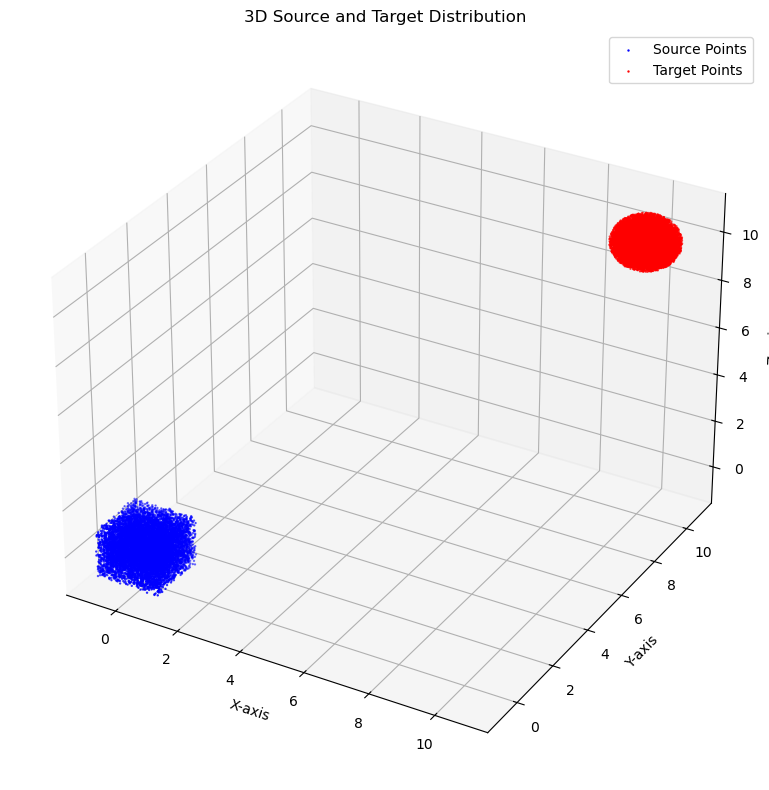

In [5]:
#----------------- plot source and target points -----------------
fig, ax = plot_points_3d(
    X, x_tgt,
    labels=['Source Points', 'Target Points'],
    colors=['blue', 'red'],
    sizes=[0.5, 0.5],
    title='3D Source and Target Distribution',
)
#------------------------------------------------------------------

In [6]:
#---------- compute moments and potentials ----------
M_std = P2M_sphe(x_polar, q, p=p)
P_mom = P_sphe(M_std, x_tgt_polar)
P_dir_vec =  P_direct_cart(X, q, x_tgt, eps=1e-10)
#------------------------------------------------------

In [7]:
x1 = center
x0 = np.array([0.0, 0.0, 0.0])


L = M2L_sphe(M_std, x0, x1)

x_tgt_rel = x_tgt - x1
x_tgt_rel_polar = cart_to_sphe(x_tgt_rel)


P_local = P_L_moment(L, x_tgt_rel_polar)


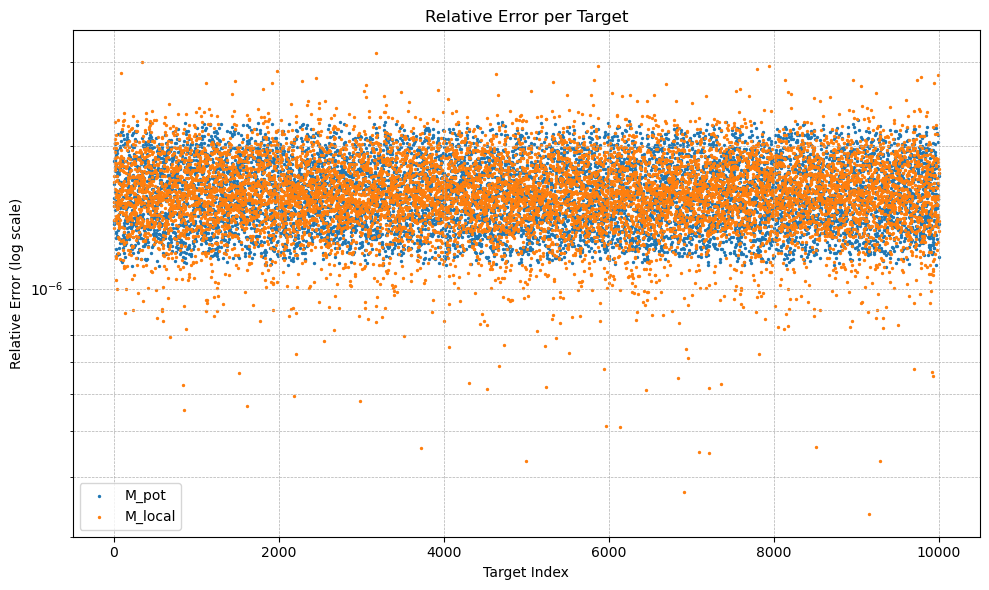

In [8]:
#--------- comput relative error between direct summation and moment evaluation ----------
relative_errors = np.abs(P_dir_vec - P_mom) / np.abs(P_dir_vec)
relative_errors_local = np.abs(P_dir_vec - P_local) / np.abs(P_dir_vec)
#------------------------------------------------------
fig, ax = plot_ylog(
    relative_errors, relative_errors_local,
    title='Relative Error per Target',
    xlabel='Target Index',
    ylabel='Relative Error (log scale)',
    sizes=[2,2],
    labels=["M_pot", "M_local"],
    legend=True
)
plt.show()

In [9]:
#------------- compute theoretical error bound at center point --------------
A = np.sum(np.abs(q))
r = np.linalg.norm(center)
a = source_area_size 
err_bound = (A / (r -a )) * ( a / r)**(p+1)
print("Theoretical error bound:", err_bound)


Theoretical error bound: 0.0003930639267628992


In [10]:
A = np.sum(np.abs(q))
a = source_area_size 
rho = np.sqrt(center[0]**2 + center[1]**2 + center[2]**2)
c = rho / a - 1.0 

err = A / (c * a - a ) * (1 / c)**(p+1)
print("Estimated error bound: ", err)

Estimated error bound:  0.0005637135296276699


In [11]:
eval_point_rel = np.array([[1.0, -1.0, 1.0]]) * 0.1 * source_area_size
eval_point_rel_polar = cart_to_sphe(eval_point_rel)


eval_point = eval_point_rel + center
eval_point_polar = cart_to_sphe(eval_point)

P_center_dir =  P_direct_cart(X, q,eval_point, eps=1e-10)[0]
P_center_mom = P_sphe(M_std, eval_point_polar)[0]
P_center_local = P_L_moment(L,eval_point_rel_polar)[0]


print("Direct eval at center: ", P_center_dir)
print("Moment expansion at center: ", P_center_mom)
print("Local expansion at center: ", P_center_local)
print("")
print("diff : ", np.abs(P_center_dir - P_center_local))
print("diff mom v local: ", np.abs(P_center_mom - P_center_local))

Direct eval at center:  -1.6411130612682059
Moment expansion at center:  -1.6411103974229102
Local expansion at center:  -1.6411103974961736

diff :  2.6637720322852942e-06
diff mom v local:  7.326339535040916e-11


In [12]:
#--------------- create list of p order and separation distances --------------
all_p = np.arange(1, 10)            
sep_dist = np.arange(2,16,2) * source_area_size
#-------------------------------------------------------------------------------
#---------- allocate arrays for results ----------
P_loc = np.zeros((len(all_p), len(sep_dist)))
P_dir = np.zeros((len(all_p), len(sep_dist)))
#------------------------------------------------
#------------- define relative evaluation point ----------
# This is done to avoid compution potential at local expansion center with r=0
# mainly because this is a singular point, and can give "false positive" results
rel_point = np.array([1.0, -1.0, 1.0]) * 0.5 * source_area_size
rel_point_polar = cart_to_sphe(np.array([rel_point]))[0]
#------------------------------------------------------
#----------------- center point for origin of moments ----------------
x0 = np.array([0.0, 0.0, 0.0])
#--------------------------------------------------------------------
#------------- loop over p and separation distances ----------
for ip, p in enumerate(all_p):
    #------------ compute moments at this p --------------
    M_x0 = P2M_sphe(x_polar, q, p=p)
    #-----------------------------------------------------
    for jd, dist in enumerate(sep_dist):
        #------------- define center point at given distance ----------
        center = np.array([1.0, 1.0, 1.0]) * dist
        x1 = rel_point + center
        point_polar = cart_to_sphe(np.array([x1]))[0]
        #--------------------------------------------------------------
        #------------- compute L expansion at this distance ----------
        L = M2L_sphe(M_x0, x0, center)
        #-------------------------------------------------------------
        #------------- evaluate potentials ----------------
        P_dir[ip, jd] =  P_direct_cart(X, q, np.array([x1]), eps=1e-10)[0]
        P_loc[ip, jd] = P_L_moment(L, rel_point_polar)[0]
        #----------------------------------------------------
#----------------------------------------------------------
#----------- compute errors ----------------
abs_err = np.abs(P_loc - P_dir)
with np.errstate(divide='ignore', invalid='ignore'):
    rel_err = abs_err / np.maximum(np.abs(P_dir), 1e-300)  # robust denominator
#--------------------------------------------

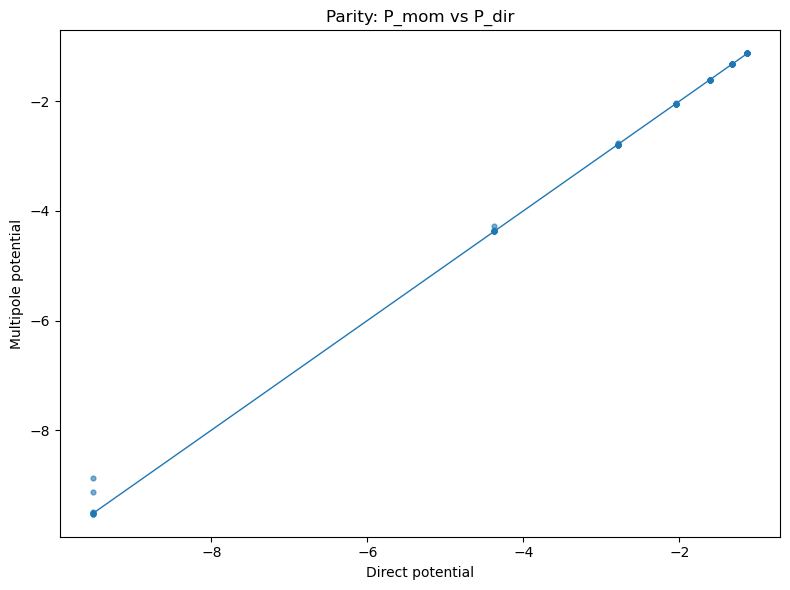

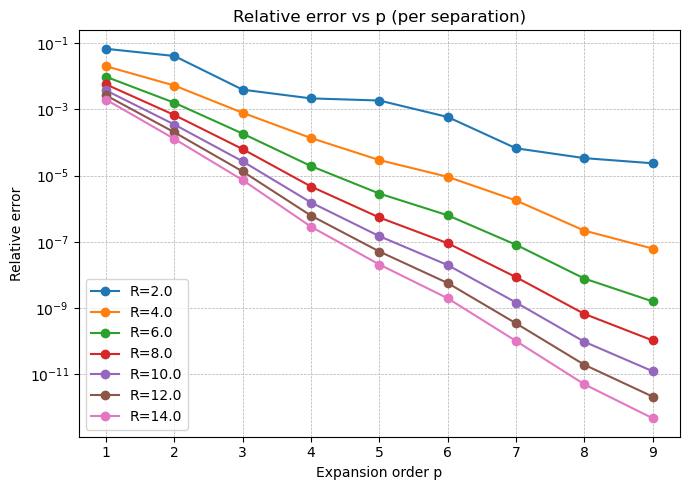

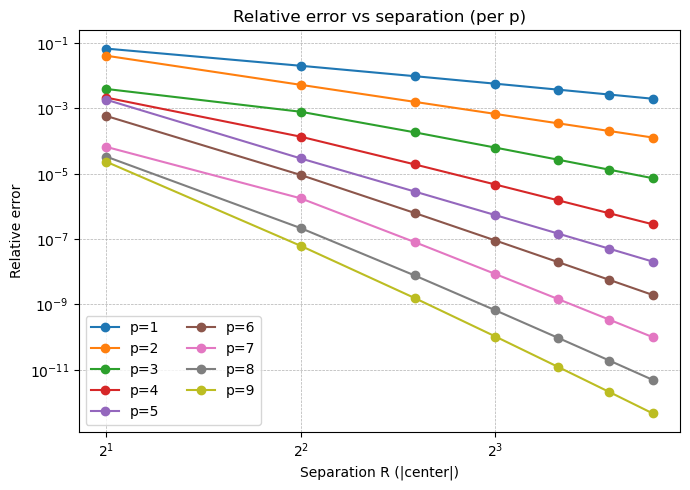

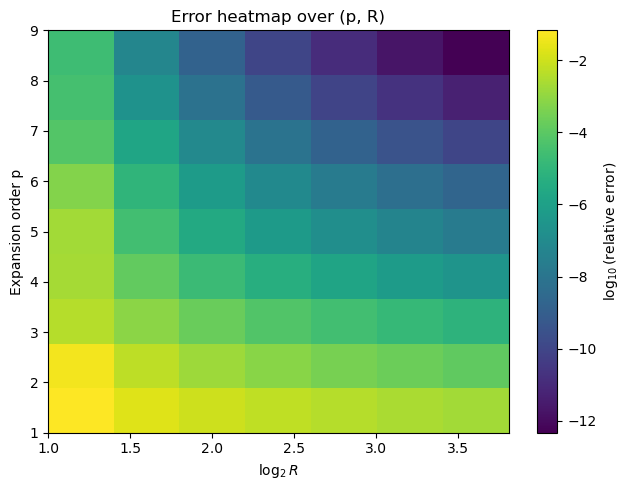

In [13]:
#---------- first plot to verify parity --------------
plt.figure(figsize=(8,6))
plt.scatter(P_dir.ravel(), P_loc.ravel(), s=12, alpha=0.6)
lims = [np.nanmin(P_dir), np.nanmax(P_dir)]
plt.plot(lims, lims, lw=1)  # y=x
plt.xlabel("Direct potential")
plt.ylabel("Multipole potential")
plt.title("Parity: P_mom vs P_dir")
plt.tight_layout()
plt.show()


# --- 1) Relative error vs p, one curve per separation ---
plt.figure(figsize=(7,5))
for j, R in enumerate(sep_dist):
    plt.plot(list(all_p), rel_err[:, j], marker='o', label=f'R={R}')
plt.yscale('log')
plt.xlabel('Expansion order p')
plt.ylabel('Relative error')
plt.title('Relative error vs p (per separation)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()

# --- 2) Relative error vs separation, one curve per p ---
plt.figure(figsize=(7,5))
for i, p in enumerate(all_p):
    plt.plot(sep_dist, rel_err[i, :], marker='o', label=f'p={p}')
plt.xscale('log', base=2)     # you used R = 2**i; base-2 makes spacing intuitive
plt.yscale('log')
plt.xlabel('Separation R (|center|)')
plt.ylabel('Relative error')
plt.title('Relative error vs separation (per p)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(ncol=2)
plt.tight_layout()

# --- 3) Heatmap of log10 relative error over (p, R) ---
plt.figure(figsize=(6.5,5))
im = plt.imshow(
    np.log10(rel_err),          # rows = p, cols = R
    origin='lower',
    aspect='auto',
    extent=[np.log2(sep_dist[0]), np.log2(sep_dist[-1]), all_p[0], all_p[-1]]
)
cbar = plt.colorbar(im, label=r'$\log_{10}(\mathrm{relative\ error})$')
plt.xlabel(r'$\log_2 R$')
plt.ylabel('Expansion order p')
plt.title('Error heatmap over (p, R)')
plt.tight_layout()

# --- Optional: magnitude/phase sanity plots (if complex) ---
if np.iscomplexobj(P_dir):
    phase_diff = np.angle(P_mom) - np.angle(P_dir)
    phase_diff = (phase_diff + np.pi) % (2*np.pi) - np.pi  # wrap to [-pi, pi]
    plt.figure(figsize=(7,4))
    for j, R in enumerate(sep_dist):
        plt.plot(list(all_p), np.abs(phase_diff[:, j]), marker='o', label=f'R={R}')
    plt.yscale('log')
    plt.xlabel('p'); plt.ylabel('abs phase diff [rad]')
    plt.title('Phase error vs p')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()

plt.show()
